/Users/ethanrong/Documents/GitHub/resumeML/backend/model
                                               title  \
0                          David_George2022_2023.pdf   
1                           Josh_Rabovsky_Resume.pdf   
2                         Full Ethan Rong Resume.pdf   
3                               Kevin_Lau_Resume.pdf   
4  Rysisca_Yau_Summer_Research_Resume_-_Dr._Amy_W...   

                                              resume  
0  David George\n587-998-4626 | dgeorge.hba2023...  
1   \n \nJosh Rabovsky  \njrabovsk @uwo.ca  | htt...  
2  ETHAN RONG ● Phone: (647) 779-9806  ● Email: e...  
3  KEVIN LAU\nUniversity of Waterloo Computer Sci...  
4  Rysisca\nY au\n( 6 4 7 )\n3 2 7 - 3 1 8 3 ,\nr...  


[nltk_data] Downloading package punkt to /Users/ethanrong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ethanrong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ethanrong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ethanrong/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


downloaded version load
1/1 [==============================] - 0s 165ms/step


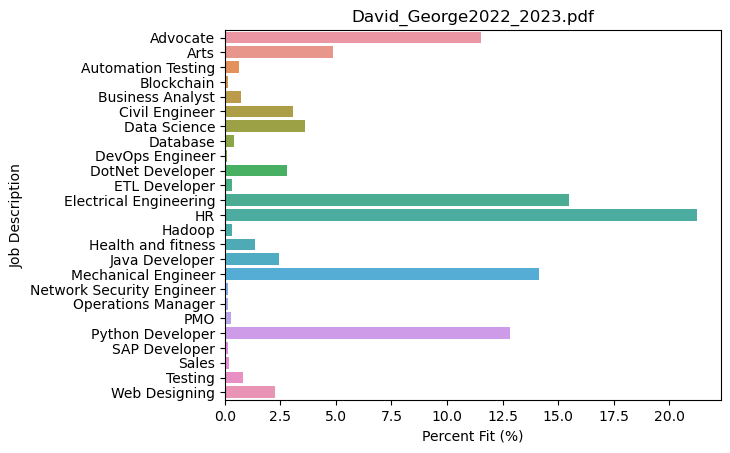

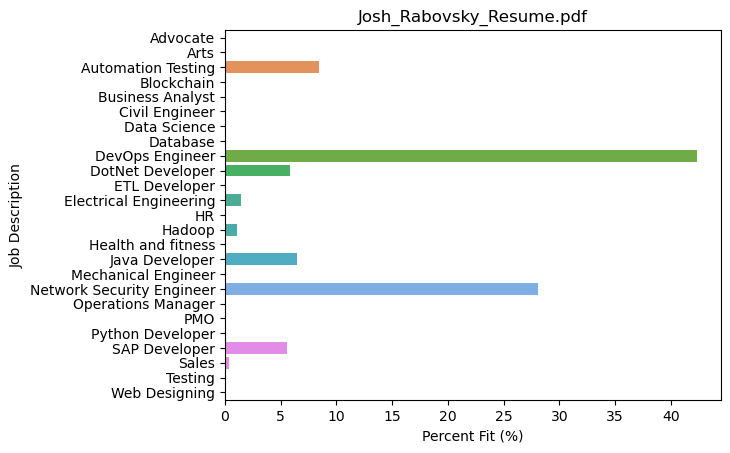

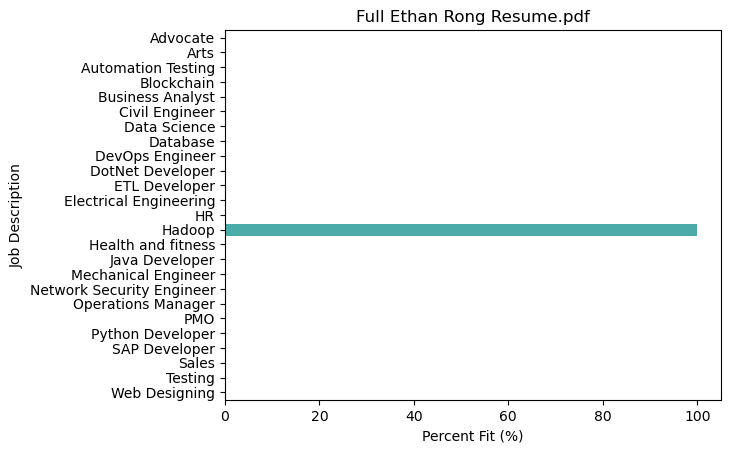

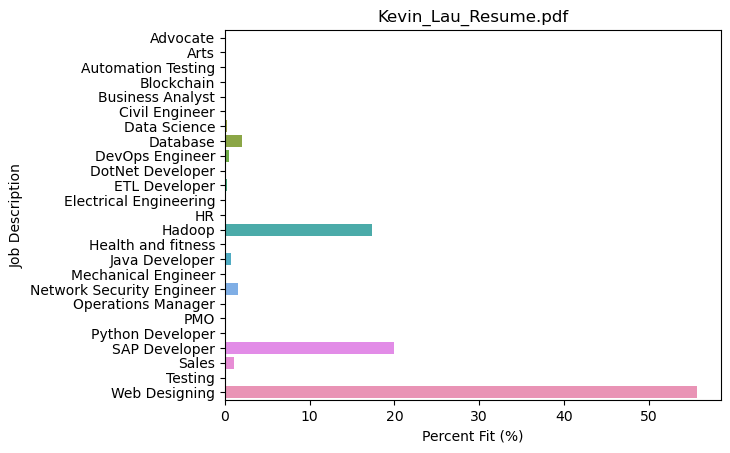

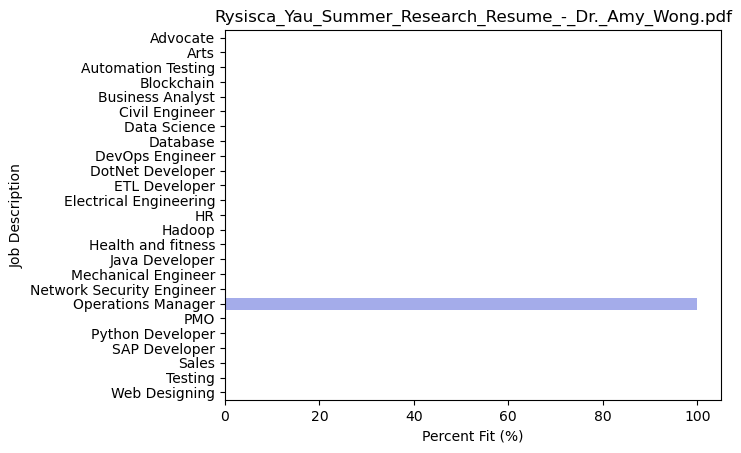

In [11]:
import os
import pickle
import re

import gensim.downloader as api
import nltk
import seaborn as sns
import numpy as np
import pandas as pd
from PyPDF2 import PdfReader
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt

INT_TO_CATG = {
    6: 'Data Science',
    12: 'HR',
    0: 'Advocate',
    1: 'Arts',
    24: 'Web Designing',
    16: 'Mechanical Engineer',
    22: 'Sales',
    14: 'Health and fitness',
    5: 'Civil Engineer',
    15: 'Java Developer',
    4: 'Business Analyst',
    21: 'SAP Developer',
    2: 'Automation Testing',
    11: 'Electrical Engineering',
    18: 'Operations Manager',
    20: 'Python Developer',
    8: 'DevOps Engineer',
    17: 'Network Security Engineer',
    19: 'PMO',
    7: 'Database',
    13: 'Hadoop',
    10: 'ETL Developer',
    9: 'DotNet Developer',
    3: 'Blockchain',
    23: 'Testing'
}


class Model:
    def __init__(self, resumePath="testResumes", modelPath="model.pkl"):
        print(os.getcwd())
        try:
            with open(modelPath, "rb") as file:
                self.model = pickle.load(file)
        except FileNotFoundError:
            print("Error No Model Found")

        if os.path.exists(resumePath):
            self.resumePath = resumePath
        else:
            print("Error Resume Path Not Found")

        self.df = None

    def _loadResumes(self):
        resumes = {
            "title": [],
            "resume": []
        }

        for resume in os.listdir(self.resumePath):
            reader = PdfReader(f"{self.resumePath}/{resume}")
            resumeContent = ""
            for i in range(len(reader.pages)):
                resumeContent += reader.pages[i].extract_text()

            resumes["title"].append(resume)
            resumes["resume"].append(resumeContent)
        self.df = pd.DataFrame(resumes)
        print(self.df)

    def _preprocessResume(self):
        # Clean Resumes
        def cleanData(uncleanedText):
            uncleanedText = re.sub(r"\b(\d{3})[-.]?(\d{3})[-.]?(\d{4})\b", "", uncleanedText)  # Removes Phone Number
            uncleanedText = re.sub(r"\b(\d{10})\b", "", uncleanedText)  # Removes Phone Number P2
            uncleanedText = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b", "",
                                   uncleanedText)  # Removes Email
            uncleanedText = re.sub("http[s]?\://\S+", "", uncleanedText)  # Removes Links
            uncleanedText = re.sub(r"(\r)|(\n)", " ", uncleanedText)  # Removes Escape Characters \r and \n
            uncleanedText = re.sub(r"(\t)", "", uncleanedText)  # Removes Escape Characters \t
            uncleanedText = re.sub("&", "and", uncleanedText)  # Replaces & With and
            uncleanedText = re.sub("\s+", " ", uncleanedText)  # Remove Extra Whitespace
            uncleanedText = re.sub(r"[^\x00-\x7f]", r" ", uncleanedText)  # Removes Non-Ascii Characters
            uncleanedText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), "",
                                   uncleanedText)  # remove punctuations
            return uncleanedText.lower()  # Lowercase everything

        self.df["resume"] = self.df.resume.apply(cleanData)

        # Downloading Required Packages
        nltk.download("punkt")
        nltk.download("stopwords")
        nltk.download('wordnet')
        nltk.download('omw-1.4')

        # Lemmatization
        def lemmatizerFunction(row):
            returnString = ""
            for word in str(row).split():
                returnString += " " + lemmatizer.lemmatize(word)
            return returnString

        lemmatizer = WordNetLemmatizer()
        self.df["resume"] = self.df["resume"].apply(lemmatizerFunction)

        # Tokenize Words
        def tokenizeFunction(row):
            return word_tokenize(row)

        self.df["resume"] = self.df["resume"].apply(tokenizeFunction)

        # Removing Stop Words
        def removeStopWords(row):
            return np.array([word for word in row if word.casefold() not in stop_words])

        stop_words = set(stopwords.words("english"))
        self.df["resume"] = self.df["resume"].apply(removeStopWords)
        
        # Cutting off Resumes to Only 1440 Words 
        self.df["resume"] = self.df["resume"].apply(lambda row: row[0:1439])

    def _vectorize(self):
        # Loading Model From Local Directory
        try:
            model = KeyedVectors.load('wordEmbeding.d2v')
            print("downloaded version load")
        except FileNotFoundError:
            print("downloading version load")
            model = api.load("fasttext-wiki-news-subwords-300")
            model.save("wordEmbeding.d2v")

        # Apply Vectorization on self.df
        def vectorizedResume(row):
            returnArray = np.array([])
            numberOfError = 0

            for i, token in enumerate(row):
                try:
                    returnArray = np.append(returnArray, np.array(model[token])).reshape(i + 1 - numberOfError, 300)
                except KeyError:
                    if token != "monthscompany":  # months company is one of the largest errors
                        numberOfError += 1
            return returnArray.T  # Transpose To Ensure Each Word Lines Down [word1, word2.....]
        self.df["resume"] = self.df["resume"].apply(vectorizedResume)

    def _addPadding(self):
        paddingAmount = 1440

        # Adding Padding
        def addPadding(row):
            pad_width = ((0, 0), (0, paddingAmount - row.shape[1]))
            return np.pad(row, pad_width, constant_values=0)
        self.df["resume"] = self.df["resume"].apply(addPadding)

    def initializeResumes(self):
        try:
            self._loadResumes()
            self._preprocessResume()
            self._vectorize()
            self._addPadding()
            return True
        except:
            print("Error Processing Resumes")
            return False

    def getPredictions(self):
        reshaped_data = self.df["resume"].apply(lambda x: np.reshape(x, (1, x.shape[0], x.shape[1])))
        X = np.concatenate(reshaped_data.to_numpy(), axis=0)
        preds = self.model.predict(X)
        returnPreds = {}

        for i, pred in enumerate(preds):
            returnPred = {}
            for j, percent in enumerate(pred):
                returnPred[INT_TO_CATG[j]] = percent * 100
            returnPreds[self.df["title"].iloc[i]] = returnPred
        return returnPreds

    def getGraphs(self, preds, save=False, show=False):
        for resumeName, pred in preds.items():
            sns.barplot(x=list(pred.values()), y=list(pred.keys()), orient="h")
            plt.xlabel("Percent Fit (%)")
            plt.ylabel("Job Description")
            plt.title(resumeName)
            plt.show() if show else None
            plt.savefig(f"savedFigures/{resumeName}.svg") if save else None

    def rank(self, preds, jobs):
        pass


if __name__ == "__main__":
    model = Model()
    model.initializeResumes()
    predictions = model.getPredictions()
    model.getGraphs(predictions, show=True)


In [9]:
model.df.iloc[4]["resume"].shape

(300, 2437)